In [6]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('tables/results_for_focalized_spikes.csv')

In [8]:
agreement_filter = df.fraction_of_yes>=7/8
confidence_filter = df.total_votes_received>=8
mode_filter = df.Mode=='Test'
N_filter = df.N==1
spikeLocations= ['frontalSpikes','centralSpikes', 'parietalSpikes', 'occipitalSpikes','temporalSpikes','generalSpikes']
channelLocations = {'frontalChannels','centralChannels','parietalChannels','occipitalChannels','temporalChannels'}

In [9]:
print('for each location, we have this many samples of high confidence and agreement:')
df[agreement_filter&confidence_filter&mode_filter&N_filter][spikeLocations].sum(axis=0)

for each location, we have this many samples of high confidence and agreement:


frontalSpikes      177.0
centralSpikes       49.0
parietalSpikes     214.0
occipitalSpikes    206.0
temporalSpikes     954.0
generalSpikes      322.0
dtype: float64

In [11]:
# location_filter = df[spikeLocation]==1

# pos = df[agreement_filter&confidence_filter&mode_filter&location_filter]
# neg = df[mode_filter&df.fraction_of_yes<1/8]

# n_samples=min([len(pos),len(neg)])
# auc_df = pd.concat([pos[:n_samples],neg[:n_samples]])
# labels = auc_df.fraction_of_yes.round(0).astype(int)

In [12]:
results={'spikeLocation':[],'channelLocation':[],'fpr':[], 'tpr':[], 'roc_auc':[],'N':[]}

for spikeLocation in spikeLocations:
    location_filter = df[spikeLocation]==1

    pos = df[agreement_filter&confidence_filter&mode_filter&location_filter&N_filter]
    neg = df[mode_filter&df.fraction_of_yes<1/8]

    n_samples=min([len(pos),len(neg)])
    auc_df = pd.concat([pos[:n_samples],neg[:n_samples]])
    labels = auc_df.fraction_of_yes.round(0).astype(int)

    for channelLocation in channelLocations:
        preds = auc_df[channelLocation].to_list()
        fpr, tpr, thresholds = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)
        results['spikeLocation'].append(spikeLocation)        
        results['channelLocation'].append(channelLocation)
        results['fpr'].append(fpr)
        results['tpr'].append(tpr)
        results['roc_auc'].append(roc_auc)
        results['N'].append(len(auc_df))

In [13]:
results = pd.DataFrame(results)
results.to_csv('tables/auc_results_crosslocation.csv',index=False)

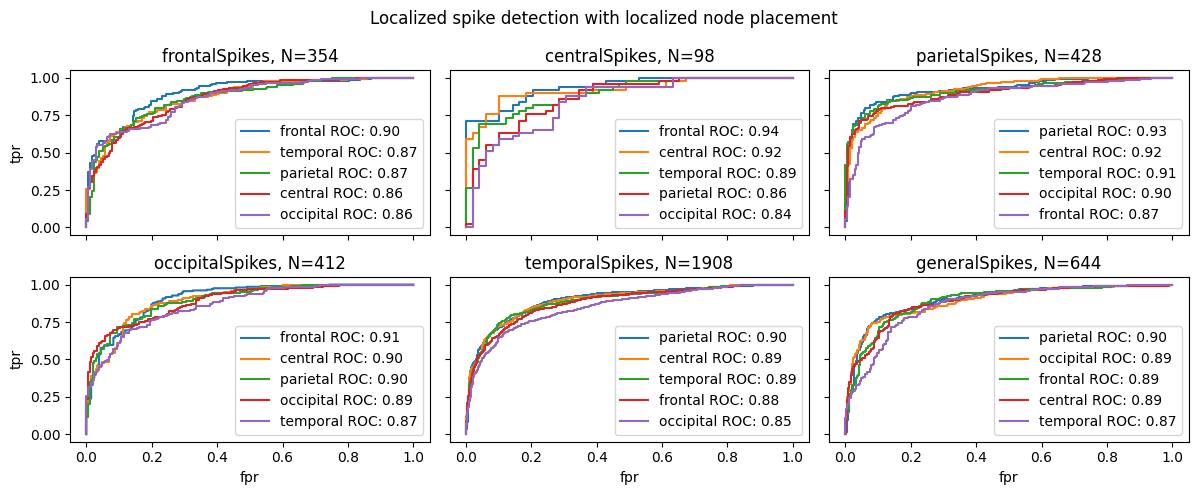

In [14]:
fig, axs = plt.subplots(2,3,figsize = (12,5),sharex=True,sharey=True)

for i in range(len(spikeLocations)):
    spikeLocation = spikeLocations[i]
    filter_spikeLocation = results.spikeLocation==spikeLocation

    sub_df = results[filter_spikeLocation].sort_values('roc_auc',ascending=False)
    for j in range(len(channelLocations)):
        sub_df = results[filter_spikeLocation].sort_values('roc_auc',ascending=False)
        channelLocation, fpr, tpr, roc_auc, N = sub_df.iloc[j][['channelLocation', 'fpr', 'tpr', 'roc_auc', 'N']]

        axs[i//3,i%3].plot(fpr,tpr,label=channelLocation.replace('Channels','')+f' ROC: {roc_auc:.2f}')
    axs[i//3,i%3].set_title(f'{spikeLocation}, N={N}')
    axs[i//3,i%3].legend()
fig.suptitle('Localized spike detection with localized node placement')
axs[0,0].set_ylabel('tpr')
axs[1,0].set_ylabel('tpr')
for j in range(3):
    axs[1,j].set_xlabel('fpr')

fig.tight_layout()
